In [16]:
# Install required packages
%pip install matplotlib numpy pandas torch


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Graph Convolutional Auto-Encoder

In [19]:
# Laplace normalization
class LplsNorm(nn.Module):
    def __init__(self):
        super(LplsNorm, self).__init__()

    def forward(self, adjacency_matrix):
        degree = torch.sum(adjacency_matrix, dim=-1)
        diag = torch.diag(torch.pow(degree, -0.5))
        out = diag.mm(adjacency_matrix).mm(diag)
        return out

# convolutional
class Convolution(nn.Module):
    def __init__(self, in_dimension, out_dimension):
        super(Convolution, self).__init__()
        self.LinearLayer = nn.Sequential(
            nn.Linear(in_dimension, out_dimension),
            nn.ReLU()
        )

    def forward(self, adjacency_matrix, feature):
        mf = feature + torch.mm(adjacency_matrix, feature)
        out = self.LinearLayer(mf)
        return out


In [ ]:
class VGAE_Encoder(nn.Module):
    def __init__(self, in_dimension, hidden_dimension, embedding_dimension):
        super(VGAE_Encoder, self).__init__()
        self.lpls_norm = LplsNorm()
        
        # Lớp GCN cơ sở
        self.base_gcn = Convolution(in_dimension, hidden_dimension)
        
        # Hai lớp tuyến tính để tạo ra mean và log_var
        self.gcn_mean = Convolution(hidden_dimension, embedding_dimension)
        self.gcn_log_var = Convolution(hidden_dimension, embedding_dimension)

    def forward(self, adj_matrix, features):
        # 1. Chuẩn hóa ma trận kề
        norm_adj = self.lpls_norm(adj_matrix)
        
        # 2. Đưa qua lớp GCN cơ sở
        hidden = self.base_gcn(norm_adj, features)
        
        # 3. Tính mean và log_var
        mean = self.gcn_mean(norm_adj, hidden)
        log_var = self.gcn_log_var(norm_adj, hidden)
        
        return mean, log_var


In [21]:
class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()

    def forward(self, z):
        # Tái tạo ma trận kề bằng cách lấy z nhân với chuyển vị của nó
        z_t = z.t()
        adj_reconstructed = torch.mm(z, z_t)
        return torch.sigmoid(adj_reconstructed)

In [22]:
class VGAE_Model(nn.Module):
    def __init__(self, in_dimension, hidden_dimension, embedding_dimension):
        super(VGAE_Model, self).__init__()
        self.encoder = VGAE_Encoder(in_dimension, hidden_dimension, embedding_dimension)
        self.decoder = InnerProductDecoder()

    def reparameterize(self, mean, log_var):
        # Thủ thuật tái tham số hóa
        if self.training:
            std = torch.exp(0.5 * log_var)
            # Lấy mẫu từ phân phối chuẩn N(0, 1)
            eps = torch.randn_like(std) 
            return eps.mul(std).add_(mean)
        else:
            # Khi kiểm tra hoặc suy luận, chỉ cần dùng mean
            return mean

    def forward(self, adj_matrix, features):
        # Mã hóa để lấy mean và log_var
        mean, log_var = self.encoder(adj_matrix, features)
        
        # Lấy mẫu z từ không gian tiềm ẩn
        z = self.reparameterize(mean, log_var)
        
        # Giải mã để tái tạo ma trận kề
        adj_reconstructed = self.decoder(z)
        
        return adj_reconstructed, mean, log_var

In [23]:
def vgae_loss_function(preds, labels, mean, log_var, num_nodes, pos_weight):
    # 1. Reconstruction Loss
    # Dùng Binary Cross Entropy với Logits để ổn định hơn
    reconstruction_loss = F.binary_cross_entropy_with_logits(
        preds.view(-1), labels.view(-1), pos_weight=pos_weight
    )
    
    # 2. KL Divergence Loss
    # Công thức tính KL divergence giữa N(mean, var) và N(0, 1)
    kl_divergence = -0.5 / num_nodes * torch.mean(torch.sum(
        1 + 2 * log_var - mean.pow(2) - (2 * log_var).exp(), dim=1
    ))
    
    return reconstruction_loss + kl_divergence

preset parameter

In [24]:
dataset = "dataset2"
lnc_mi = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_mi.csv', index_col='0').values
mi_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/mi_di.csv', index_col='0').values
lnc_di = pd.read_csv('./our_dataset/' + dataset + '/interaction/lnc_di.csv', index_col='0').values
L_num = lnc_mi.shape[0]
D_num = mi_di.shape[1]
M_num = mi_di.shape[0]
print(f"{L_num} --- {D_num} --- {M_num}")

665 --- 316 --- 295


In [25]:
A = np.load('./our_dataset/' + dataset + '/A/A_1_1.npy')
folds = 5
in_dimension = A.shape[1]
embedding_dimension = 128
learn_rate = 1e-2
weight_decay = 1e-4
n_epochs = 200
network_num = 4
hidden_dimension=64

train

In [26]:
# Giả sử các hàm VGAE_Model và vgae_loss_function đã được định nghĩa ở trên

print("Start training VGAE")
rds = []
res = [] # List này sẽ lưu trữ 'mu'

for fold in range(folds):
    # CẢI TIẾN 1: Khởi tạo model và optimizer MỘT LẦN cho mỗi fold
    # Điều này cho phép model học hỏi qua tất cả các đồ thị trong một fold.
    model = VGAE_Model(in_dimension, hidden_dimension, embedding_dimension) # Giả sử dùng VGAE_Model đã định nghĩa
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)
    
    d = [] # Lưu kết quả tái tạo của fold hiện tại
    e = [] # Lưu vector tiềm ẩn 'mu' của fold hiện tại

    for i in range(network_num):
        epoch = 0
        A_numpy = np.load('./our_dataset/' + dataset + '/A/A_' + str(fold + 1) + '_' + str(i + 1) + '.npy')
        A = torch.Tensor(A_numpy)
        num_nodes = A.shape[0]

        # CẢI TIẾN 2: Tạo ma trận kề với self-loops
        adj_input = A + torch.eye(num_nodes)
        
        # CẢI TIẾN 3: Sử dụng ma trận đơn vị làm features ban đầu
        features_input = torch.eye(num_nodes)

        # (Tùy chọn nhưng khuyến khích) Tính pos_weight để xử lý đồ thị thưa
        pos_weight = torch.tensor(float(num_nodes**2 - adj_input.sum()) / adj_input.sum())

        while epoch < n_epochs:
            model.train()
            optimizer.zero_grad()
            
            # Forward pass với input đã được xử lý
            reconstructed_A, mu, log_var = model(adj_input, features_input)
            
            # CẢI TIẾN 4: Gọi hàm loss với đầy đủ tham số
            loss = vgae_loss_function(reconstructed_A, adj_input, mu, log_var, num_nodes, pos_weight)
            
            loss.backward()
            optimizer.step()
            epoch += 1
            
        # --- Phần đánh giá (Evaluation) ---
        model.eval()
        with torch.no_grad():
            # Sử dụng cùng input đã xử lý để đánh giá
            rd, mu, log_var = model(adj_input, features_input)
            d.append(rd.cpu().numpy()) # Chuyển về numpy để lưu trữ nếu cần
            
            # Lưu 'mu' làm vector biểu diễn tiềm ẩn
            e.append(mu.cpu().numpy())
            
        print(f"Fold {fold + 1}, Graph {i + 1}, Final Loss: {loss.item()}")
    
    res.append(e)
    rds.append(d)

print("Training finished!")

Start training VGAE
Fold 1, Graph 1, Final Loss: 1.2912273406982422
Fold 1, Graph 2, Final Loss: 1.2220141887664795
Fold 1, Graph 3, Final Loss: 1.215523362159729
Fold 1, Graph 4, Final Loss: 1.2143527269363403
Fold 2, Graph 1, Final Loss: 1.2867391109466553
Fold 2, Graph 2, Final Loss: 1.224853277206421
Fold 2, Graph 3, Final Loss: 1.2187788486480713
Fold 2, Graph 4, Final Loss: 1.21786367893219
Fold 3, Graph 1, Final Loss: 1.2912451028823853
Fold 3, Graph 2, Final Loss: 1.1752026081085205
Fold 3, Graph 3, Final Loss: 1.1657506227493286
Fold 3, Graph 4, Final Loss: 1.1656312942504883
Fold 4, Graph 1, Final Loss: 1.2915308475494385
Fold 4, Graph 2, Final Loss: 1.2181141376495361
Fold 4, Graph 3, Final Loss: 1.2124003171920776
Fold 4, Graph 4, Final Loss: 1.2117968797683716
Fold 5, Graph 1, Final Loss: 1.2904375791549683
Fold 5, Graph 2, Final Loss: 1.2178077697753906
Fold 5, Graph 3, Final Loss: 1.211694598197937
Fold 5, Graph 4, Final Loss: 1.2106609344482422
Training finished!


In [27]:
# print("Start training")
# rds = []
# res = []
# for fold in range(folds):
#     d = []
#     e = []
#     for i in range(network_num):
#         epoch = 0
#         A = torch.Tensor(np.load('./our_dataset/' + dataset + '/A/A_' + str(fold + 1) + '_' + str(i + 1) + '.npy'))
        # model = GraphConvolution(in_dimension, embedding_dimension)
        # optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)
        # loss_function = nn.MSELoss(reduction='mean')
#         while epoch < n_epochs:
#             model.train()
#             optimizer.zero_grad()
#             rd, re = model(A, A)
#             loss = loss_function(rd, A)
#             loss.backward()
#             optimizer.step()
#             epoch += 1
#         model.eval()
#         with torch.no_grad():
#             rd, re = model(A, A)
#             d.append(rd)
#             e.append(re)
#         print(f"The layer {fold + 1} graph convolutional auto-encoder loss is {loss.detach().cpu().item()}")
#     res.append(e)
#     rds.append(d)

Save the results

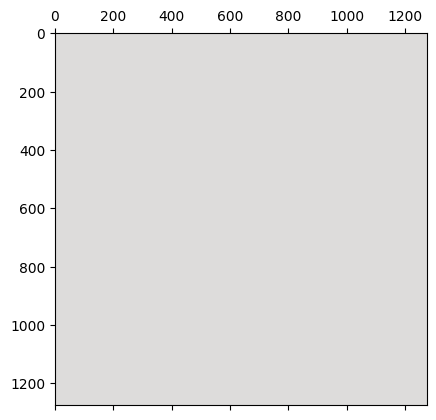

In [28]:
import os

output_dir = './our_dataset/' + dataset + '/A_vgae_encoder'
os.makedirs(output_dir, exist_ok=True)

for fold in range(folds):
    for i in range(network_num):
        file_path = os.path.join(output_dir, f'A_{fold + 1}_{i + 1}.npy')
        np.save(file_path, res[fold][i])

plt.matshow(rds[0][0], cmap=plt.cm.coolwarm, vmin=0, vmax=1)